<a href="https://colab.research.google.com/github/unnxp/MelNoteClassifier-changed-from-AutoPitch-/blob/main/MelNoteClassifierModelTrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install librosa
!pip install tensorflow
!pip install numpy
!pip install matplotlib
!pip install json

ERROR: Could not find a version that satisfies the requirement json (from versions: none)
ERROR: No matching distribution found for json


In [2]:
import librosa
import librosa.display
import numpy as np
import json
import os
import tensorflow as tf
import matplotlib.pyplot as plt

# ‡πÇ‡∏´‡∏•‡∏î Metadata
metadata_path = "/content/drive/My Drive/dataset/nsynth-train/examples.json"
audio_dir = "/content/drive/My Drive/dataset/nsynth-train/audio"

with open(metadata_path, "r") as f:
    metadata = json.load(f)

# ‡∏ü‡∏±‡∏á‡∏Å‡πå‡∏ä‡∏±‡∏ô‡πÇ‡∏´‡∏•‡∏î‡πÄ‡∏™‡∏µ‡∏¢‡∏á‡πÅ‡∏•‡∏∞‡πÅ‡∏õ‡∏•‡∏á‡πÄ‡∏õ‡πá‡∏ô Mel-Spectrogram
def load_audio(file_path):
    y, sr = librosa.load(file_path, sr=16000)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    # Normalization
    mel_spec_db = (mel_spec_db - np.min(mel_spec_db)) / (np.max(mel_spec_db) - np.min(mel_spec_db))
    mel_spec_db = tf.image.resize(mel_spec_db[..., np.newaxis], (128, 128))  # ‡∏õ‡∏£‡∏±‡∏ö‡∏Ç‡∏ô‡∏≤‡∏î‡πÄ‡∏õ‡πá‡∏ô (128,128,1)

    return mel_spec_db, sr



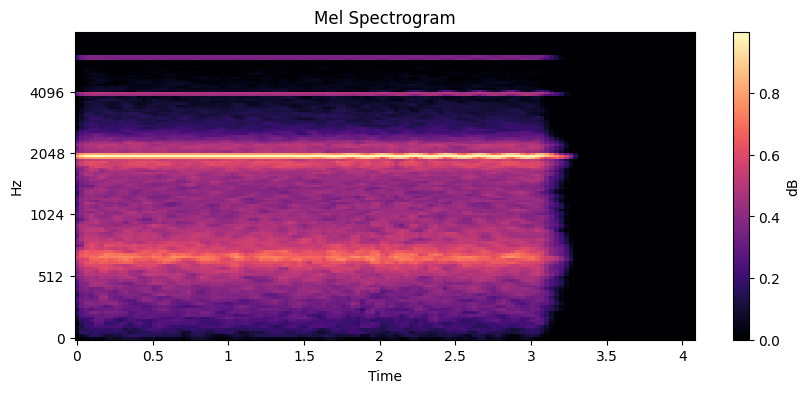

In [9]:
import numpy as np

# If mel_spec has an extra dimension (e.g., shape like (1, 128, 128)), remove it
mel_spec = np.squeeze(mel_spec)

# ‡πÅ‡∏™‡∏î‡∏á Mel-Spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spec, sr=sr, x_axis="time", y_axis="mel")
plt.colorbar(label="dB")
plt.title("Mel Spectrogram")
plt.show()


In [ ]:
# üîπ ‡∏™‡∏£‡πâ‡∏≤‡∏á Data Generator (‡πÄ‡∏•‡∏∑‡∏≠‡∏Å 20000 ‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡πÅ‡∏£‡∏Å)
min_pitch, max_pitch = 0, 127  # MIDI Range
max_samples = 20000  # üî• ‡∏à‡∏≥‡∏Å‡∏±‡∏î‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏ó‡∏µ‡πà 20000 ‡∏ï‡∏±‡∏ß‡∏≠‡∏¢‡πà‡∏≤‡∏á
def data_generator():
    count = 0
    for i, (key, info) in enumerate(metadata.items()):
        if count >= max_samples:
            break  # ‡∏´‡∏¢‡∏∏‡∏î‡πÄ‡∏°‡∏∑‡πà‡∏≠‡∏Ñ‡∏£‡∏ö 20000 ‡∏ï‡∏±‡∏ß‡∏≠‡∏¢‡πà‡∏≤‡∏á

        file_name = key + ".wav"  # üîπ ‡πÉ‡∏ä‡πâ key ‡πÄ‡∏õ‡πá‡∏ô‡∏ä‡∏∑‡πà‡∏≠‡πÑ‡∏ü‡∏•‡πå
        file_path = os.path.join(audio_dir, file_name)

        if not os.path.exists(file_path):
            print(f"‚ùå File not found: {file_path}")  # ‡πÅ‡∏à‡πâ‡∏á‡πÄ‡∏ï‡∏∑‡∏≠‡∏ô‡πÑ‡∏ü‡∏•‡πå‡∏´‡∏≤‡∏¢
            continue

        mel_spec, _ = load_audio(file_path)
        pitch = info["pitch"]

        if not (min_pitch <= pitch <= max_pitch):
            continue  # ‡∏Ç‡πâ‡∏≤‡∏°‡πÇ‡∏ô‡πâ‡∏ï‡∏ó‡∏µ‡πà‡∏≠‡∏¢‡∏π‡πà‡∏ô‡∏≠‡∏Å‡∏ä‡πà‡∏ß‡∏á

        count += 1
        yield mel_spec, pitch - min_pitch  # ‚úÖ Shift pitch ‡πÉ‡∏´‡πâ‡πÄ‡∏£‡∏¥‡πà‡∏°‡∏ó‡∏µ‡πà 0

    print(f"‚úÖ Total samples loaded: {count}")

batch_size = 64
dataset = tf.data.Dataset.from_generator(
    data_generator,
    output_signature=(
        tf.TensorSpec(shape=(128, 128, 1), dtype=tf.float32),  # ‚úÖ ‡πÄ‡∏õ‡∏•‡∏µ‡πà‡∏¢‡∏ô‡πÄ‡∏õ‡πá‡∏ô (128,128,1)
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
)

dataset = dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [ ]:
for mel_batch, pitch_batch in dataset.batch(32).take(1):
    print("Batch shape:", mel_batch.shape, "Pitch shape:", pitch_batch.shape)

In [ ]:
from tensorflow import keras
from keras import layers

input_shape = (128, 128, 1)

model = keras.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", padding="same", input_shape=input_shape),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation="relu", padding="same"),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation="relu", padding="same"),
    layers.MaxPooling2D((2,2)),

    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation="relu"),
    layers.Dense(128, activation="softmax")  # ‚úÖ 128 ‡∏Ñ‡∏•‡∏≤‡∏™ (0-127)
])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_5"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                         ‚îÉ Output Shape                ‚îÉ         Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ conv2d_15 (Conv2D)                   ‚îÇ (None, 128, 128, 32)        ‚îÇ             320 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_15 (MaxPooling2D)      ‚îÇ (None, 64, 64, 32)          ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_16 (Conv2D)                   ‚îÇ (None, 64, 64, 64)          ‚îÇ          18,496 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_16 (MaxPooling2D)      ‚îÇ (None, 32, 32, 64)          ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_17 (Conv2D)                   ‚îÇ (None, 32, 32, 128)         ‚îÇ          73,856 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_17 (MaxPooling2D)      ‚îÇ (None, 16, 16, 128)         ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ global_average_pooling2d_5           ‚îÇ (None, 128)                 ‚îÇ               0 ‚îÇ
‚îÇ (GlobalAveragePooling2D)             ‚îÇ                             ‚îÇ                 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_10 (Dense)                     ‚îÇ (None, 256)                 ‚îÇ          33,024 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_11 (Dense)                     ‚îÇ (None, 128)                 ‚îÇ          32,896 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 158,592 (619.50 KB)

 Trainable params: 158,592 (619.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ‡∏ù‡∏∂‡∏Å‡πÇ‡∏°‡πÄ‡∏î‡∏•‡∏î‡πâ‡∏ß‡∏¢ dataset ‡∏ó‡∏µ‡πà‡∏™‡∏£‡πâ‡∏≤‡∏á‡πÑ‡∏ß‡πâ
model.fit(dataset, epochs=10)


Epoch 1/10
    296/Unknown 395s 1s/step - accuracy: 0.0181 - loss: 4.5156‚úÖ Total samples loaded: 20000
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 398s 1s/step - accuracy: 0.0194 - loss: 4.5008
Epoch 2/10
296/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 17s 1s/step - accuracy: 0.1741 - loss: 3.2793‚úÖ Total samples loaded: 20000
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 318s 965ms/step - accuracy: 0.1775 - loss: 3.2664
Epoch 3/10
296/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 17s 1s/step - accuracy: 0.3541 - loss: 2.5550‚úÖ Total samples loaded: 20000
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 316s 959ms/step - accuracy: 0.3561 - loss: 2.5481
Epoch 4/10
296/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 17s 1s/step - accuracy: 0.4460 - loss: 2.1992‚úÖ Total samples loaded: 20000
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3

In [ ]:
# ‡πÇ‡∏´‡∏•‡∏î‡∏ï‡∏±‡∏ß‡∏≠‡∏¢‡πà‡∏≤‡∏á‡πÄ‡∏™‡∏µ‡∏¢‡∏á‡πÉ‡∏´‡∏°‡πà
test_file = "/content/drive/My Drive/dataset/nsynth-train/audio/vocal_synthetic_012-086-100.wav"
test_mel, _ = load_audio(test_file)

# ‡πÅ‡∏õ‡∏•‡∏á‡πÄ‡∏õ‡πá‡∏ô Tensor
test_mel = np.expand_dims(test_mel, axis=(0, -1))  # Reshape ‡πÄ‡∏õ‡πá‡∏ô (1, 128, Time, 1)

# ‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡πÇ‡∏ô‡πâ‡∏ï
prediction = model.predict(test_mel)
predicted_pitch = np.argmax(prediction)

print(f"Predicted Pitch: {predicted_pitch}")


1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 502ms/step
Predicted Pitch: 88


In [ ]:
# ‡∏ö‡∏±‡∏ô‡∏ó‡∏∂‡∏Å‡πÇ‡∏°‡πÄ‡∏î‡∏•‡∏´‡∏•‡∏±‡∏á‡∏à‡∏≤‡∏Å‡∏Å‡∏≤‡∏£‡∏ù‡∏∂‡∏Å
model.save('/content/drive/My Drive/dataset/MelNoteClassifierV2.h5')


# **‡∏ï‡πà‡∏≠‡πÑ‡∏õ‡∏à‡∏∞‡πÄ‡∏õ‡πá‡∏ô‡∏Å‡∏≤‡∏£ finetune**

In [ ]:
# ‡∏Å‡∏≥‡∏´‡∏ô‡∏î‡∏ä‡πà‡∏ß‡∏á‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏ó‡∏µ‡πà‡∏ï‡πâ‡∏≠‡∏á‡∏Å‡∏≤‡∏£
start_idx = 20000  # ‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡πÄ‡∏£‡∏¥‡πà‡∏°‡∏ï‡πâ‡∏ô‡∏ó‡∏µ‡πà index 20001 (‡∏ï‡∏±‡∏ß‡∏ó‡∏µ‡πà 20001 ‡∏Ñ‡∏∑‡∏≠ index 20000)
end_idx = 50000    # ‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏™‡∏¥‡πâ‡∏ô‡∏™‡∏∏‡∏î‡∏ó‡∏µ‡πà index 50000 (‡∏ï‡∏±‡∏ß‡∏ó‡∏µ‡πà 50000 ‡∏Ñ‡∏∑‡∏≠ index 49999)

def data_generator():
    count = 0
    for i, (key, info) in enumerate(metadata.items()):
        if i < start_idx:
            continue  # ‡∏Ç‡πâ‡∏≤‡∏°‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏ó‡∏µ‡πà‡∏ô‡πâ‡∏≠‡∏¢‡∏Å‡∏ß‡πà‡∏≤ 20001

        if i >= end_idx:
            break  # ‡∏´‡∏¢‡∏∏‡∏î‡πÄ‡∏°‡∏∑‡πà‡∏≠‡∏ñ‡∏∂‡∏á‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏ó‡∏µ‡πà 50000

        file_name = key + ".wav"
        file_path = os.path.join(audio_dir, file_name)

        if not os.path.exists(file_path):
            print(f"‚ùå File not found: {file_path}")
            continue

        mel_spec, _ = load_audio(file_path)
        pitch = info["pitch"]

        if not (min_pitch <= pitch <= max_pitch):
            continue

        count += 1
        yield mel_spec, pitch - min_pitch  # Shift pitch ‡πÉ‡∏´‡πâ‡πÄ‡∏£‡∏¥‡πà‡∏°‡∏ó‡∏µ‡πà 0

    print(f"‚úÖ Total samples loaded: {count}")


In [ ]:
from keras.models import load_model

# ‡πÇ‡∏´‡∏•‡∏î‡πÇ‡∏°‡πÄ‡∏î‡∏•‡∏ó‡∏µ‡πà‡∏ö‡∏±‡∏ô‡∏ó‡∏∂‡∏Å
model = load_model('/content/drive/My Drive/dataset/MelNoteClassifier.h5')

In [ ]:
# ‡∏ó‡∏≥‡πÉ‡∏´‡πâ‡∏ä‡∏±‡πâ‡∏ô‡∏Å‡πà‡∏≠‡∏ô‡∏´‡∏ô‡πâ‡∏≤‡∏ô‡∏µ‡πâ‡πÑ‡∏°‡πà‡∏™‡∏≤‡∏°‡∏≤‡∏£‡∏ñ‡∏ù‡∏∂‡∏Å‡πÑ‡∏î‡πâ
for layer in model.layers[:-2]:  # ‡∏õ‡∏£‡∏±‡∏ö‡πÄ‡∏â‡∏û‡∏≤‡∏∞ 2 ‡∏ä‡∏±‡πâ‡∏ô‡∏™‡∏∏‡∏î‡∏ó‡πâ‡∏≤‡∏¢
    layer.trainable = False

# ‡∏Ñ‡∏≠‡∏°‡πÑ‡∏û‡∏•‡πå‡πÇ‡∏°‡πÄ‡∏î‡∏•‡πÉ‡∏´‡∏°‡πà
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])


In [ ]:
# ‡∏™‡∏£‡πâ‡∏≤‡∏á Dataset ‡πÉ‡∏´‡∏°‡πà‡∏à‡∏≤‡∏Å data generator
dataset = tf.data.Dataset.from_generator(
    data_generator,
    output_signature=(
        tf.TensorSpec(shape=(128, 128, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
)

dataset = dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# ‡πÉ‡∏ä‡πâ ReduceLROnPlateau ‡πÄ‡∏û‡∏∑‡πà‡∏≠‡∏•‡∏î learning rate ‡πÄ‡∏°‡∏∑‡πà‡∏≠ loss ‡πÑ‡∏°‡πà‡∏•‡∏î‡∏•‡∏á
lr_scheduler = ReduceLROnPlateau(monitor="loss", factor=0.5, patience=3, min_lr=1e-6)

# ‡∏ù‡∏∂‡∏Å‡πÇ‡∏°‡πÄ‡∏î‡∏•‡∏î‡πâ‡∏ß‡∏¢ callback
model.fit(dataset, epochs=10, callbacks=[lr_scheduler])

Epoch 1/10
    453/Unknown 755s 2s/step - accuracy: 0.6486 - loss: 1.3999‚úÖ Total samples loaded: 30000
469/469 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 762s 2s/step - accuracy: 0.6489 - loss: 1.3988 - learning_rate: 0.0010
Epoch 2/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


453/469 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 23s 1s/step - accuracy: 0.6701 - loss: 1.3059‚úÖ Total samples loaded: 30000
469/469 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 685s 1s/step - accuracy: 0.6701 - loss: 1.3055 - learning_rate: 0.0010
Epoch 3/10
453/469 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 23s 1s/step - accuracy: 0.6765 - loss: 1.2586‚úÖ Total samples loaded: 30000
469/469 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 697s 1s/step - accuracy: 0.6766 - loss: 1.2582 - learning_rate: 0.0010
Epoch 4/10
453/469 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 23s 1s/step - accuracy: 0.6855 - loss: 1.2162‚úÖ Total samples loaded: 30000
469/469 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 688s 1s/step - accuracy: 0.6855 - loss: 1.2160 - learning_rate: 0.0010
Epoch 5/10
453/469 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 23s 1s/step - accuracy: 0.6925 - loss: 1

In [ ]:
model.save('/content/drive/My Drive/dataset/MelNoteClassifierV2.h5')

In [ ]:
from keras.models import load_model

# ‡πÇ‡∏´‡∏•‡∏î‡πÇ‡∏°‡πÄ‡∏î‡∏•‡∏ó‡∏µ‡πà‡∏ö‡∏±‡∏ô‡∏ó‡∏∂‡∏Å
base_model = load_model('/content/drive/My Drive/dataset/MelNoteClassifierV4.h5')

In [ ]:
for layer in base_model.layers[:-5]:  # Freeze ‡∏ó‡∏∏‡∏Å‡πÄ‡∏•‡πÄ‡∏¢‡∏≠‡∏£‡πå ‡∏¢‡∏Å‡πÄ‡∏ß‡πâ‡∏ô 5 ‡∏ä‡∏±‡πâ‡∏ô‡∏™‡∏∏‡∏î‡∏ó‡πâ‡∏≤‡∏¢
    layer.trainable = False
for layer in base_model.layers[-5:]:  # ‡∏õ‡∏•‡∏î‡∏•‡πá‡∏≠‡∏Å 5 ‡∏ä‡∏±‡πâ‡∏ô‡∏™‡∏∏‡∏î‡∏ó‡πâ‡∏≤‡∏¢
    layer.trainable = True

In [ ]:
train_start_idx, train_end_idx = 60000,70000
val_start_idx, val_end_idx = 70000, 78750  # Validation set
test_start_idx, test_end_idx = 78750, 87500  # Test set

def data_generator(start_idx, end_idx):
    count = 0
    for i, (key, info) in enumerate(metadata.items()):
        if i < start_idx:
            continue  # ‡∏Ç‡πâ‡∏≤‡∏°‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏ó‡∏µ‡πà‡πÑ‡∏°‡πà‡πÉ‡∏ä‡πâ

        if i >= end_idx:
            break  # ‡∏´‡∏¢‡∏∏‡∏î‡πÄ‡∏°‡∏∑‡πà‡∏≠‡∏ñ‡∏∂‡∏á‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏ó‡∏µ‡πà end_idx

        file_name = key + ".wav"
        file_path = os.path.join(audio_dir, file_name)

        if not os.path.exists(file_path):
            print(f"‚ùå File not found: {file_path}")
            continue

        mel_spec, _ = load_audio(file_path)  # ‡πÇ‡∏´‡∏•‡∏î‡πÄ‡∏™‡∏µ‡∏¢‡∏á‡πÅ‡∏•‡∏∞‡πÅ‡∏õ‡∏•‡∏á‡πÄ‡∏õ‡πá‡∏ô Mel-Spectrogram
        pitch = info["pitch"]

        count += 1
        yield mel_spec, pitch - min_pitch  # Shift pitch ‡πÉ‡∏´‡πâ‡πÄ‡∏£‡∏¥‡πà‡∏°‡∏ó‡∏µ‡πà 0

    print(f"‚úÖ Total samples loaded: {count}")

# ‡∏™‡∏£‡πâ‡∏≤‡∏á Dataset ‡πÉ‡∏´‡∏°‡πà‡∏à‡∏≤‡∏Å data generator

train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(train_start_idx, train_end_idx),
    output_signature=(tf.TensorSpec(shape=(128, 128, 1), dtype=tf.float32), tf.TensorSpec(shape=(), dtype=tf.int32))
).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Validation set
val_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(val_start_idx, val_end_idx),
    output_signature=(tf.TensorSpec(shape=(128, 128, 1), dtype=tf.float32), tf.TensorSpec(shape=(), dtype=tf.int32))
).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Test set
test_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(test_start_idx, test_end_idx),
    output_signature=(tf.TensorSpec(shape=(128, 128, 1), dtype=tf.float32), tf.TensorSpec(shape=(), dtype=tf.int32))
).batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [ ]:
fine_tune_model = base_model  # ‡πÉ‡∏ä‡πâ base_model ‡∏ó‡∏µ‡πà‡πÄ‡∏ó‡∏£‡∏ô‡πÑ‡∏ß‡πâ‡πÅ‡∏•‡πâ‡∏ß

# ‡∏•‡∏î Learning Rate ‡πÄ‡∏û‡∏∑‡πà‡∏≠ Fine-tune ‡πÉ‡∏´‡πâ‡πÅ‡∏°‡πà‡∏ô‡∏Ç‡∏∂‡πâ‡∏ô
fine_tune_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                        loss="sparse_categorical_crossentropy",
                        metrics=["accuracy"])

In [ ]:
fine_tune_model.fit(train_dataset, epochs=10,validation_data=val_dataset)

Epoch 1/10
    156/Unknown 147s 923ms/step - accuracy: 0.6823 - loss: 1.2648‚úÖ Total samples loaded: 10000
    157/Unknown 151s 945ms/step - accuracy: 0.6823 - loss: 1.2648

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


‚úÖ Total samples loaded: 8750
157/157 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 280s 2s/step - accuracy: 0.6823 - loss: 1.2648 - val_accuracy: 0.7016 - val_loss: 1.1765
Epoch 2/10
156/157 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 927ms/step - accuracy: 0.7009 - loss: 1.2075‚úÖ Total samples loaded: 10000
157/157 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 922ms/step - accuracy: 0.7009 - loss: 1.2077‚úÖ Total samples loaded: 8750
157/157 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 317s 2s/step - accuracy: 0.7009 - loss: 1.2078 - val_accuracy: 0.7025 - val_loss: 1.1694
Epoch 3/10
156/157 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 921ms/step - accuracy: 0.7056 - loss: 1.1904‚úÖ Total samples loaded: 10000
157/157 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 917ms/step - accuracy: 0.7055 - loss: 1.1906‚úÖ Total samples loaded: 8750
157/157 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

‡∏õ‡∏£‡∏∞‡πÄ‡∏°‡∏¥‡∏ô‡∏ú‡∏•

In [ ]:
test_loss, test_acc = fine_tune_model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")

    136/Unknown 130s 952ms/step - accuracy: 0.7020 - loss: 1.1761‚úÖ Total samples loaded: 8750
137/137 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 130s 951ms/step - accuracy: 0.7021 - loss: 1.1758
Test Accuracy: 0.7070


In [ ]:
model.save('/content/drive/My Drive/dataset/MelNoteClassifierV3.h5')

In [ ]:
from keras.models import load_model

# 1. ‡πÇ‡∏´‡∏•‡∏î‡πÇ‡∏°‡πÄ‡∏î‡∏•‡∏ó‡∏µ‡πà‡∏ö‡∏±‡∏ô‡∏ó‡∏∂‡∏Å (‡πÇ‡∏°‡πÄ‡∏î‡∏•‡∏ó‡∏µ‡πà‡πÄ‡∏ó‡∏£‡∏ô‡πÑ‡∏õ‡πÅ‡∏•‡πâ‡∏ß)
base_model = load_model('/content/drive/My Drive/dataset/MelNoteClassifierV2.h5')

In [ ]:
# 2. Freeze ‡πÄ‡∏•‡πÄ‡∏¢‡∏≠‡∏£‡πå‡∏ó‡∏±‡πâ‡∏á‡∏´‡∏°‡∏î ‡∏¢‡∏Å‡πÄ‡∏ß‡πâ‡∏ô 5 ‡∏ä‡∏±‡πâ‡∏ô‡∏™‡∏∏‡∏î‡∏ó‡πâ‡∏≤‡∏¢
for layer in base_model.layers[:-5]:  # Freeze ‡∏ó‡∏∏‡∏Å‡πÄ‡∏•‡πÄ‡∏¢‡∏≠‡∏£‡πå ‡∏¢‡∏Å‡πÄ‡∏ß‡πâ‡∏ô 5 ‡∏ä‡∏±‡πâ‡∏ô‡∏™‡∏∏‡∏î‡∏ó‡πâ‡∏≤‡∏¢
    layer.trainable = False

for layer in base_model.layers[-5:]:  # ‡∏õ‡∏•‡∏î‡∏•‡πá‡∏≠‡∏Å 5 ‡∏ä‡∏±‡πâ‡∏ô‡∏™‡∏∏‡∏î‡∏ó‡πâ‡∏≤‡∏¢
    layer.trainable = True

# 3. ‡πÄ‡∏ï‡∏£‡∏µ‡∏¢‡∏°‡πÇ‡∏°‡πÄ‡∏î‡∏•‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö fine-tune
# ‡∏Ñ‡∏∏‡∏ì‡πÑ‡∏°‡πà‡∏ï‡πâ‡∏≠‡∏á‡∏™‡∏£‡πâ‡∏≤‡∏á‡πÇ‡∏°‡πÄ‡∏î‡∏•‡πÉ‡∏´‡∏°‡πà‡πÄ‡∏û‡∏£‡∏≤‡∏∞‡πÄ‡∏£‡∏≤‡πÉ‡∏ä‡πâ base_model ‡∏ó‡∏µ‡πà‡πÇ‡∏´‡∏•‡∏î‡∏°‡∏≤‡πÅ‡∏•‡πâ‡∏ß
fine_tune_model = base_model

# 4. ‡∏•‡∏î Learning Rate ‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö fine-tune
fine_tune_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                        loss="sparse_categorical_crossentropy",
                        metrics=["accuracy"])

# 5. ‡∏ù‡∏∂‡∏Å‡πÇ‡∏°‡πÄ‡∏î‡∏• (Fine-tune) ‡πÄ‡∏û‡∏¥‡πà‡∏°
history = fine_tune_model.fit(train_dataset,
                    epochs=20,  # ‡πÄ‡∏û‡∏¥‡πà‡∏° epochs ‡∏ï‡∏≤‡∏°‡∏ó‡∏µ‡πà‡∏ï‡πâ‡∏≠‡∏á‡∏Å‡∏≤‡∏£
                    validation_data=val_dataset)  # ‡πÉ‡∏ä‡πâ validation data



Epoch 1/20
    156/Unknown 154s 966ms/step - accuracy: 0.6823 - loss: 1.2648‚úÖ Total samples loaded: 10000
    157/Unknown 155s 968ms/step - accuracy: 0.6823 - loss: 1.2648‚úÖ Total samples loaded: 8750
157/157 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 286s 2s/step - accuracy: 0.6823 - loss: 1.2648 - val_accuracy: 0.7016 - val_loss: 1.1765
Epoch 2/20
156/157 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 958ms/step - accuracy: 0.7009 - loss: 1.2075‚úÖ Total samples loaded: 10000
157/157 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 954ms/step - accuracy: 0.7009 - loss: 1.2077‚úÖ Total samples loaded: 8750
157/157 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 280s 2s/step - accuracy: 0.7009 - loss: 1.2078 - val_accuracy: 0.7025 - val_loss: 1.1694
Epoch 3/20
156/157 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 961ms/step - accuracy: 0.7056 - loss: 1.1904‚úÖ Total samples loaded: 10000
157/157 ‚îÅ‚îÅ‚

In [ ]:
fine_tune_model.save('/content/drive/My Drive/dataset/MelNoteClassifierV5.h5')

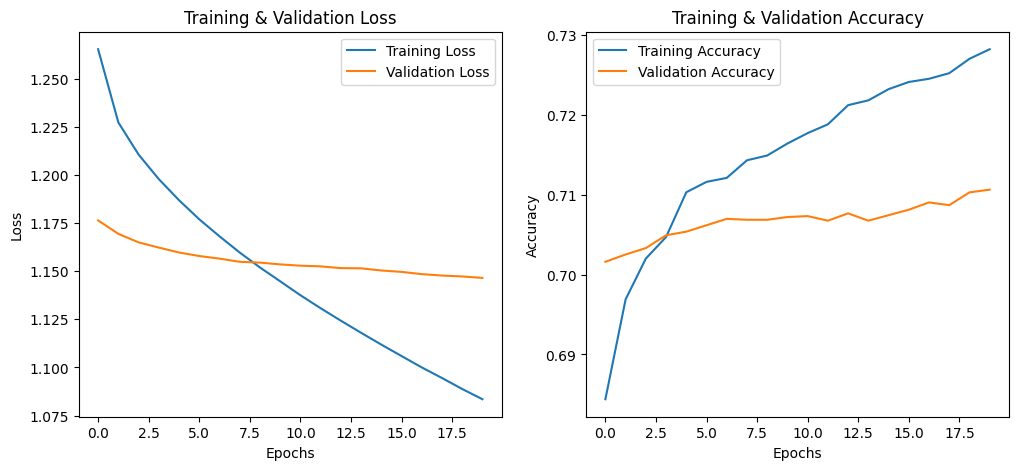

In [ ]:
import matplotlib.pyplot as plt

# ‡∏û‡∏•‡πá‡∏≠‡∏ï‡∏Å‡∏£‡∏≤‡∏ü Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# ‡∏û‡∏•‡πá‡∏≠‡∏ï‡∏Å‡∏£‡∏≤‡∏ü Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()


In [ ]:
batch_size = 64

In [ ]:
val_start_idx, val_end_idx = 70000, 78750
new_start_idx, new_end_idx = 100044, 110028
test_start_idx, test_end_idx = 78750, 87500
def data_generator(start_idx, end_idx):
    count = 0
    for i, (key, info) in enumerate(metadata.items()):
        if i < start_idx:
            continue  # ‡∏Ç‡πâ‡∏≤‡∏°‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏ó‡∏µ‡πà‡πÑ‡∏°‡πà‡πÉ‡∏ä‡πâ

        if i >= end_idx:
            break  # ‡∏´‡∏¢‡∏∏‡∏î‡πÄ‡∏°‡∏∑‡πà‡∏≠‡∏ñ‡∏∂‡∏á‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏ó‡∏µ‡πà end_idx

        file_name = key + ".wav"
        file_path = os.path.join(audio_dir, file_name)

        if not os.path.exists(file_path):
            print(f"‚ùå File not found: {file_path}")
            continue

        mel_spec, _ = load_audio(file_path)  # ‡πÇ‡∏´‡∏•‡∏î‡πÄ‡∏™‡∏µ‡∏¢‡∏á‡πÅ‡∏•‡∏∞‡πÅ‡∏õ‡∏•‡∏á‡πÄ‡∏õ‡πá‡∏ô Mel-Spectrogram
        pitch = info["pitch"]

        count += 1
        yield mel_spec, pitch - min_pitch  # Shift pitch ‡πÉ‡∏´‡πâ‡πÄ‡∏£‡∏¥‡πà‡∏°‡∏ó‡∏µ‡πà 0

    print(f"‚úÖ Total samples loaded: {count}")

new_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(new_start_idx, new_end_idx),
    output_signature=(tf.TensorSpec(shape=(128, 128, 1), dtype=tf.float32),tf.TensorSpec(shape=(), dtype=tf.int32))
).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    # Validation set
val_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(val_start_idx, val_end_idx),
    output_signature=(tf.TensorSpec(shape=(128, 128, 1), dtype=tf.float32), tf.TensorSpec(shape=(), dtype=tf.int32))
).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Test set
test_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(test_start_idx, test_end_idx),
    output_signature=(tf.TensorSpec(shape=(128, 128, 1), dtype=tf.float32), tf.TensorSpec(shape=(), dtype=tf.int32))
).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

# ‡πÇ‡∏´‡∏•‡∏î‡πÇ‡∏°‡πÄ‡∏î‡∏•‡∏ó‡∏µ‡πà‡πÄ‡∏ó‡∏£‡∏ô‡πÑ‡∏ß‡πâ‡πÅ‡∏•‡πâ‡∏ß (‡∏™‡∏°‡∏°‡∏∏‡∏ï‡∏¥‡∏ß‡πà‡∏≤‡πÄ‡∏õ‡πá‡∏ô Sequential model)
base_model = load_model('/content/drive/My Drive/dataset/MelNoteClassifierV5.h5')
fine_tune_model2 = base_model
# Freeze ‡πÄ‡∏•‡πÄ‡∏¢‡∏≠‡∏£‡πå: ‡∏õ‡∏•‡∏î‡∏•‡πá‡∏≠‡∏Å‡πÄ‡∏â‡∏û‡∏≤‡∏∞ 5 ‡∏ä‡∏±‡πâ‡∏ô‡∏™‡∏∏‡∏î‡∏ó‡πâ‡∏≤‡∏¢
for layer in base_model.layers[:-5]:
    layer.trainable = False
for layer in base_model.layers[-5:]:
    layer.trainable = True

# ‡∏™‡∏°‡∏°‡∏∏‡∏ï‡∏¥‡∏ß‡πà‡∏≤ output ‡∏Ç‡∏≠‡∏á‡πÇ‡∏°‡πÄ‡∏î‡∏•‡πÄ‡∏õ‡πá‡∏ô Dense layer ‡∏ó‡∏µ‡πà‡∏à‡∏≥‡πÅ‡∏ô‡∏Å‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡∏Ñ‡∏•‡∏≤‡∏™

# ‡∏•‡∏î Learning Rate ‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö Fine-tuning
fine_tune_model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

# ‡∏™‡∏£‡πâ‡∏≤‡∏á Early Stopping Callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# ‡πÄ‡∏ó‡∏£‡∏ô‡πÇ‡∏°‡πÄ‡∏î‡∏• (new_dataset ‡πÅ‡∏•‡∏∞ val_dataset ‡∏ï‡πâ‡∏≠‡∏á‡∏ñ‡∏π‡∏Å‡πÄ‡∏ï‡∏£‡∏µ‡∏¢‡∏°‡πÑ‡∏ß‡πâ‡πÅ‡∏•‡πâ‡∏ß)
history = fine_tune_model2.fit(new_dataset,
                               epochs=20,
                               validation_data=val_dataset,
                               callbacks=[early_stop])


Epoch 1/20
    155/Unknown 139s 882ms/step - accuracy: 0.7204 - loss: 1.1400‚úÖ Total samples loaded: 9984
    156/Unknown 140s 881ms/step - accuracy: 0.7205 - loss: 1.1399

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


‚úÖ Total samples loaded: 8750
156/156 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 261s 2s/step - accuracy: 0.7205 - loss: 1.1399 - val_accuracy: 0.7123 - val_loss: 1.1228
Epoch 2/20
155/156 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 883ms/step - accuracy: 0.7269 - loss: 1.1133‚úÖ Total samples loaded: 9984
156/156 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 882ms/step - accuracy: 0.7270 - loss: 1.1133‚úÖ Total samples loaded: 8750
156/156 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 261s 2s/step - accuracy: 0.7270 - loss: 1.1132 - val_accuracy: 0.7120 - val_loss: 1.1206
Epoch 3/20
155/156 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 881ms/step - accuracy: 0.7302 - loss: 1.1014‚úÖ Total samples loaded: 9984
156/156 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 881ms/step - accuracy: 0.7303 - loss: 1.1013‚úÖ Total samples loaded: 8750
156/156 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î

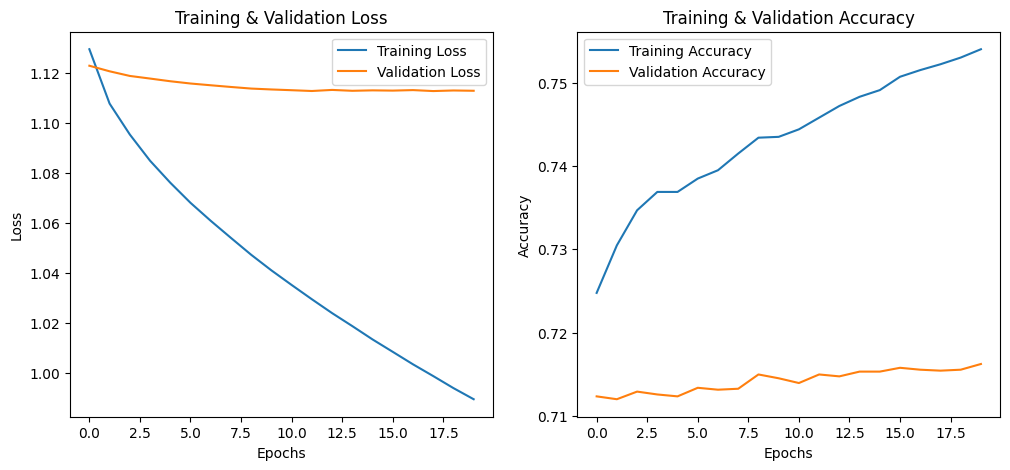

In [ ]:
import matplotlib.pyplot as plt

# ‡∏û‡∏•‡πá‡∏≠‡∏ï‡∏Å‡∏£‡∏≤‡∏ü Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# ‡∏û‡∏•‡πá‡∏≠‡∏ï‡∏Å‡∏£‡∏≤‡∏ü Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()

In [ ]:
base_model.save('/content/drive/My Drive/dataset/MelNoteClassifierV7.h5')